# Fronts and fishing footprint analysis

This notebook analayse the if the fishing footprint is coincident with SST fronts. SST data is read directly from Copernicus via an OpenDAP connection. Note, that if the internet connection is lost it may fail in some parts.

This notebooks is structures in the following parts.

1. Import libraries and set input parameters
2. Fetch SST data and compute fronts
3. Read fishing footprint and check coincidence with fronts
4. Daily comparison of fishing footprint and fronts coincidence
5. Comparison for the entire period




# 1 - Import libraries and set input parameters

## Libraries imports

In [1]:
from fronts_module.compute_fronts_functions import compute_fronts_main
from fronts_module.input_data_functions import get_coast_buffer,get_coastline,polygon_to_gdf,opendap_data,get_SST_data_pydap
import shapely
from datetime import date
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import cartopy


## Input paramaters and auxiliary data

In [2]:
# Time parameters
start_date = date(2018, 7, 1)
end_date = date(2018, 7, 15)

# Spatial parameters 
aoi_str= "POLYGON((-18.625982999801632 44.04603059481223,-6.804693937301631 44.04603059481223,-6.804693937301631 35.7352403878994,-18.625982999801632 35.7352403878994,-18.625982999801632 44.04603059481223))"
aoi = shapely.wkt.loads(aoi_str)
coastline_directory = "./aux_data/global_coastline_shapefile"
coastline_aoi = get_coastline(aoi,coastline_directory)
coast_buffer =  get_coast_buffer(coastline_aoi,15)
aoi_gdf = polygon_to_gdf(aoi)


# 2 - Fetch SST data and compute fronts

## Create OpeNDAP connection to fetch SST from Copernicus

In [3]:
data_collection = opendap_data(start_date,end_date)

## Plot SST sample of data 

Just a plot of the end date to check that data is correct

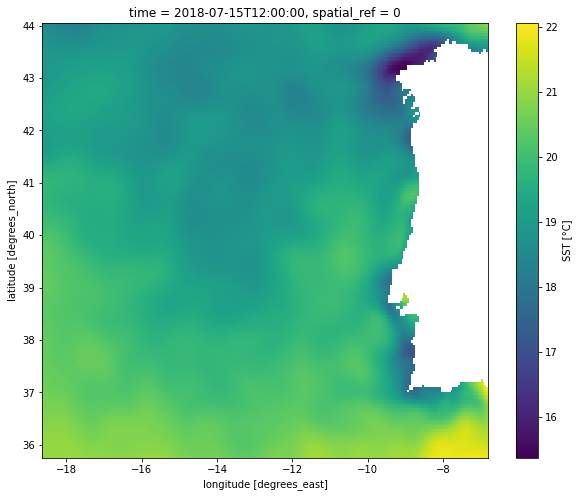

In [4]:
SST_data = get_SST_data_pydap(aoi_gdf,data_collection.sel(time=end_date.strftime('%Y-%m-%d')))
plt.figure(figsize=(10,8))
SST_data.plot(cbar_kwargs={'label':'SST [°C]'})
plt.show()

## Compute daily fronts

Iterate from start to end date to compute fronts for each date

In [5]:
fronts_xarray_list = []

for _date in list(pd.date_range(start_date,end_date,freq='d')):
    data_daily = data_collection.sel(time=_date.strftime('%Y-%m-%d'))
    fronts_xarray = compute_fronts_main(data_daily,aoi_gdf,coast_buffer)
    dummy_fishing_footprint_xarray = fronts_xarray
    fronts_xarray_list.append(fronts_xarray)

fronts_xarray_all = xr.concat(fronts_xarray_list,dim='time')


## Fronts sample plot

Just a plot of the end date to check that data is correct

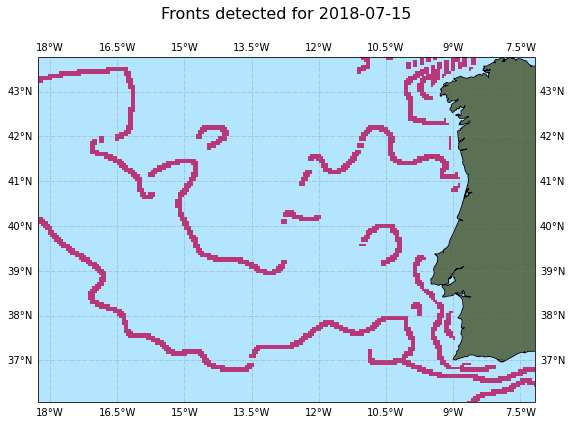

In [6]:
plt.figure(figsize=(10,6))

ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True,
                    linewidth=.6, color='gray', alpha=0.5, linestyle='-.')
ax.set_extent([min(fronts_xarray_all.lon), max(fronts_xarray_all.lon), 
               min(fronts_xarray_all.lat), max(fronts_xarray_all.lat)], 
              crs=cartopy.crs.PlateCarree())

ax.add_feature(cartopy.feature.LAND,facecolor='#5C7053')
ax.add_feature(cartopy.feature.OCEAN,facecolor='#B4E5FF')
ax.add_feature(cartopy.feature.COASTLINE)

fronts_xarray_all.sel(time=end_date.strftime('%Y-%m-%d')).plot(add_colorbar=False,cmap='magma')
plt.title('Fronts detected for ' + end_date.strftime('%Y-%m-%d')+'\n',fontsize='16')
plt.tight_layout()


plt.show()

## Fronts sample plot and SST

Just a plot of fronts and SST for the end date to check that data is correct

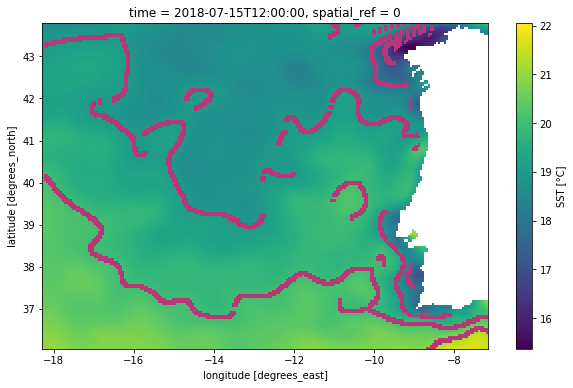

In [7]:
fig, ax1 = plt.subplots(figsize=(10,6))
SST_data.plot(cbar_kwargs={'label':'SST [°C]'})

# Add secondary axis with fronts

ax2 = ax.secondary_yaxis('right')
ax2.set_ticks([])

fronts_xarray_all.sel(time=end_date.strftime('%Y-%m-%d')).plot(add_colorbar=False,cmap='magma')


# 3 - Read fishing footprint and check coincidence with fronts


## Create dummy fishing footprint data

As this data is quite sensible it cannot be share. Therefore random data it is generated to do the analysis

In [8]:
dummy_fishing_footprint_list = []

for _date in list(pd.date_range(start_date,end_date,freq='d')):
    
    dummy_xarray = xr.DataArray(
                data=np.random.rand(len(SST_data.lat),len(SST_data.lon)),
                dims=["lat", "lon"],
                coords={'lat':SST_data.lat.values,'lon':SST_data.lon.values,'time':_date} )
    # We remove the greate majority of the data to simulate fishing footprint, which is scattered and confined in certain points
    dummy_xarray= dummy_xarray.where(dummy_xarray>0.99,other=np.nan)*10
    dummy_fishing_footprint_list.append(dummy_xarray)

dummy_xarray_all = xr.concat(dummy_fishing_footprint_list,dim='time')


## Daily fronts and footprint coincidence

In [9]:
stats_df = pd.DataFrame(columns = ["Date", "Total footprint [H]", 
                                   "Coincident footprint [H]","Percentage coincident"])
coincident_fishing_footprint_list = []

for _date in list(pd.date_range(start_date,end_date,freq='d')):
    # Selects fronts and footprint data for the date
    fronts_date = fronts_xarray_all.sel(time=_date.strftime('%Y-%m-%d'))
    dummy_data_date = dummy_xarray_all.sel(time=_date.strftime('%Y-%m-%d'))
    # Check coincidence of footprint and fronts. 
    # In this case fronts is already in a bitmask format(0 and 1), so multiplying by footprint data is enough
    coincident_footprint = dummy_data_date*fronts_date
    coincident_fishing_footprint_list.append(coincident_footprint)

    # Save statistics about fishing footprint
    total_footprint_nbr = np.nansum(dummy_data_date)
    coincident_hours_nbr = np.nansum(coincident_footprint)
    new_row = {'Date':_date.strftime('%Y-%m-%d'), 
               'Total footprint [H]':total_footprint_nbr, 
               'Coincident footprint [H]':coincident_hours_nbr,
               'Percentage coincident':(coincident_hours_nbr/total_footprint_nbr)*100}
    
    stats_df = pd.concat([stats_df, pd.DataFrame([new_row])])

coincident_footprint_xarray_all = xr.concat(coincident_fishing_footprint_list,dim='time')


# 4 - Daily comparison of fishing footprint and fronts coincidence


## Bar chart of daily fishing footprint

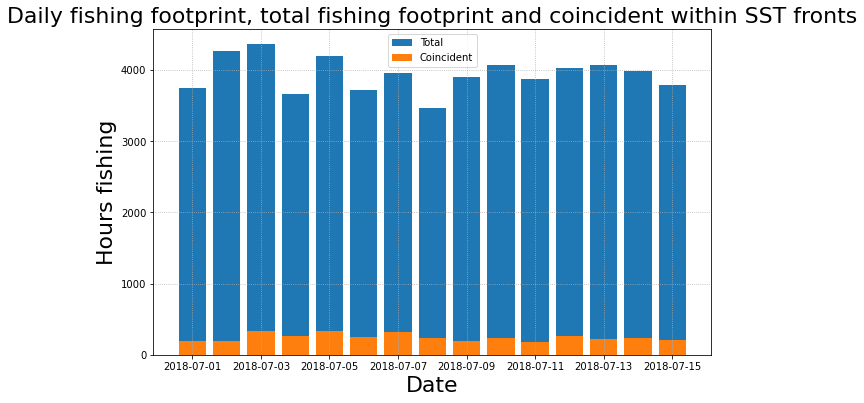

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
ax.grid(True, linestyle = 'dotted',zorder = -1)

dates = list(pd.date_range(start_date,end_date,freq='d'))
ax.bar(dates,stats_df['Total footprint [H]'],  label = 'Total')
ax.bar(dates,stats_df['Coincident footprint [H]'],  label = 'Coincident')


plt.xlabel("Date", fontsize=22)
plt.ylabel("Hours fishing", fontsize=22)
plt.title("Daily fishing footprint, total fishing footprint and coincident within SST fronts", fontsize = 22)
plt.legend()
plt.show()

# Line chart of percentage of fishing hours within fronts

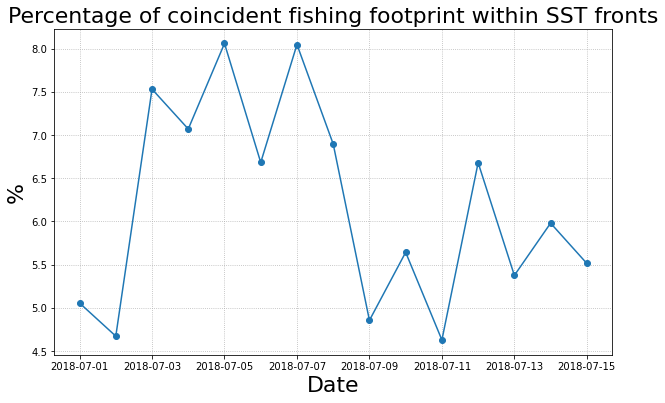

In [11]:
fig, ax = plt.subplots(figsize=(10,6))
ax.grid(True, linestyle = 'dotted',zorder = -1)

dates = list(pd.date_range(start_date,end_date,freq='d'))
ax.plot(dates,stats_df['Percentage coincident'], '-o')


plt.xlabel("Date", fontsize=22)
plt.ylabel("%", fontsize=22)
plt.title("Percentage of coincident fishing footprint within SST fronts", fontsize = 22)
plt.show()

# 5 - Comparison for the entire period

## Fronts density for the entire period

The temporal aggregation of daily fronts for a given period it is defined as fronts density

In [12]:
fronts_density_xarray = fronts_xarray_all.sum(dim='time')
fronts_density_xarray= fronts_density_xarray.where(fronts_density_xarray>0,other=np.nan)

## Fronts density plot

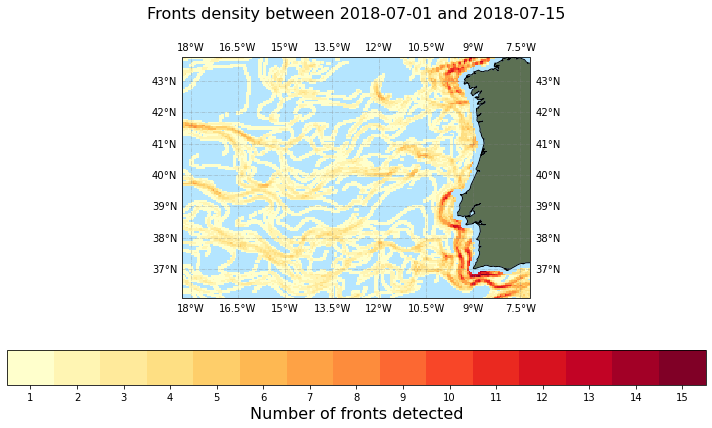

In [13]:
plt.figure(figsize=(10,6))

ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True,
                    linewidth=.6, color='gray', alpha=0.5, linestyle='-.')
ax.set_extent([min(fronts_density_xarray.lon), max(fronts_density_xarray.lon), 
               min(fronts_density_xarray.lat), max(fronts_density_xarray.lat)], 
              crs=cartopy.crs.PlateCarree())

ax.add_feature(cartopy.feature.LAND,facecolor='#5C7053')
ax.add_feature(cartopy.feature.OCEAN,facecolor='#B4E5FF')
ax.add_feature(cartopy.feature.COASTLINE)

fig = fronts_density_xarray.plot(cmap='YlOrRd',add_colorbar=False)
cbar_ticks = np.arange(0,fronts_density_xarray.max()+1)
cbar = plt.colorbar(fig,orientation='horizontal',ticks=cbar_ticks,boundaries=cbar_ticks+0.5)
cbar.set_label('Number of fronts detected',fontsize='16')
plt.title('Fronts density between '+str(start_date)+' and '+str(end_date)+'\n',fontsize='16')


plt.tight_layout()
plt.show()

## Fishing footprint for the entire period


In [14]:
footprint_entire_period_xarray = coincident_footprint_xarray_all.sum(dim='time')
footprint_entire_period_xarray= footprint_entire_period_xarray.where(footprint_entire_period_xarray>0,other=np.nan)


## Fronts density and fishinig footprint plot

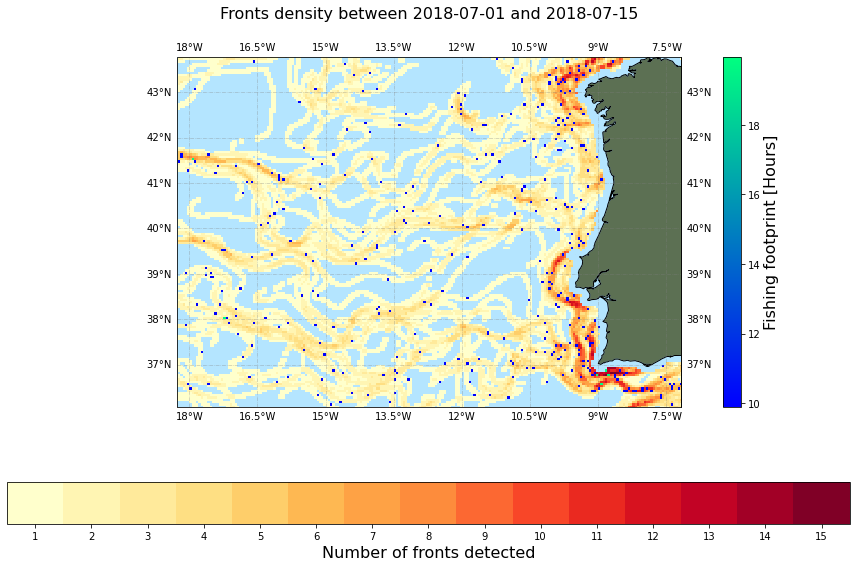

In [15]:
plt.figure(figsize=(12,8))

ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True,
                    linewidth=.6, color='gray', alpha=0.5, linestyle='-.')
ax.set_extent([min(fronts_density_xarray.lon), max(fronts_density_xarray.lon), 
               min(fronts_density_xarray.lat), max(fronts_density_xarray.lat)], 
              crs=cartopy.crs.PlateCarree())

ax.add_feature(cartopy.feature.LAND,facecolor='#5C7053')
ax.add_feature(cartopy.feature.OCEAN,facecolor='#B4E5FF')
ax.add_feature(cartopy.feature.COASTLINE)

fig = fronts_density_xarray.plot(cmap='YlOrRd',add_colorbar=False)
cbar_ticks = np.arange(0,fronts_density_xarray.max()+1)
cbar = plt.colorbar(fig,orientation='horizontal',ticks=cbar_ticks,boundaries=cbar_ticks+0.5)
cbar.set_label('Number of fronts detected',fontsize='16')

# Add secondary axis with fishing footprint

ax2 = ax.secondary_yaxis('right')
ax2.set_ticks([])
fig_footprint = footprint_entire_period_xarray.plot(cmap='winter',add_colorbar=False)
cbar_footprint = plt.colorbar(fig_footprint,orientation='vertical')
cbar_footprint.set_label('Fishing footprint [Hours]',fontsize='16')


plt.title('Fronts density between '+str(start_date)+' and '+str(end_date)+'\n',fontsize='16')
plt.tight_layout()
plt.show()

## Histogram of the fronts class

In here we check in which front density class the fishing footprint falls in

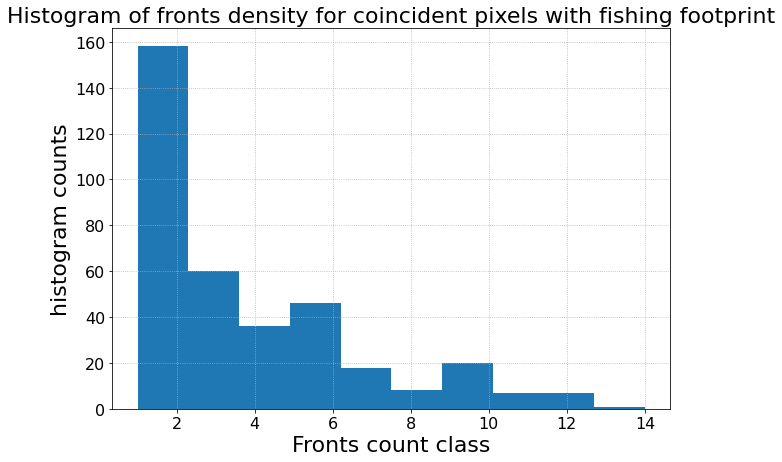

In [16]:
from matplotlib.ticker import MaxNLocator

fronts_in_footprint_classes = (footprint_entire_period_xarray/footprint_entire_period_xarray)*(fronts_density_xarray)
fronts_classes_values = fronts_in_footprint_classes.values
fronts_classes_values = fronts_classes_values[~np.isnan(fronts_classes_values)]


fig, ax = plt.subplots(figsize =(10, 7))
ax.grid(True, linestyle = 'dotted',zorder = -1)

ax.hist(fronts_classes_values)
plt.xlabel("Fronts count class", fontsize=22)
plt.ylabel("histogram counts", fontsize=22)
plt.title("Histogram of fronts density for coincident pixels with fishing footprint", fontsize = 22)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()


## Scatter plot fronts vs footprint

In here we check if there is any correlation between high density fronts and high fishing footprint values

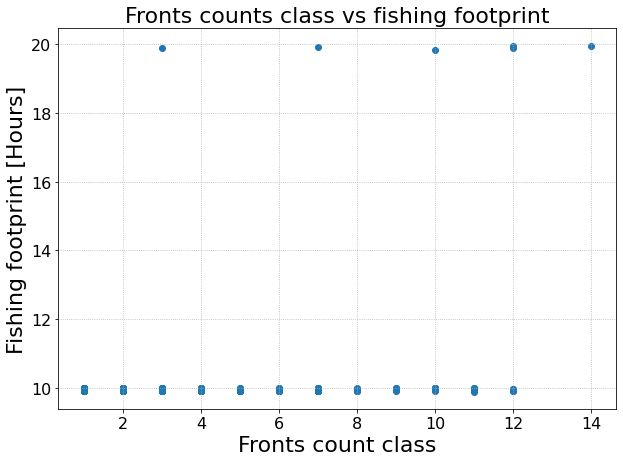

In [17]:

footprint_values = footprint_entire_period_xarray.values
footprint_values = footprint_values[~np.isnan(footprint_values)]
fig, ax = plt.subplots(figsize =(10, 7))
ax.grid(True, linestyle = 'dotted',zorder = -1)

ax.scatter(fronts_classes_values,footprint_values)

plt.xlabel("Fronts count class", fontsize=22)
plt.ylabel("Fishing footprint [Hours]", fontsize=22)
plt.title("Fronts counts class vs fishing footprint", fontsize = 22)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()



## Bar chart of fishing time per front class

In this plot it is show the acummulated fishing time per front density class

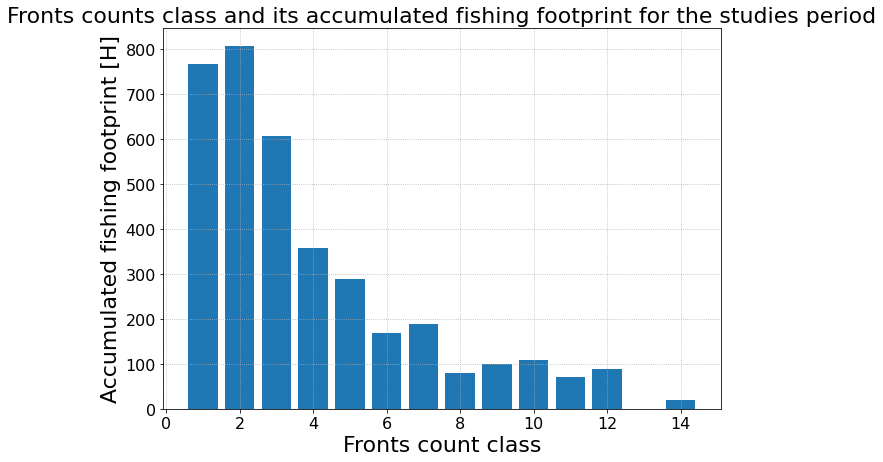

In [18]:

fronts_count_and_fishing_time_df = pd.DataFrame(data = {"Fronts density count":fronts_classes_values, "Footprint value":footprint_values})

sum_df  = fronts_count_and_fishing_time_df.groupby('Fronts density count').sum(['Footprint value'])

fig, ax = plt.subplots(figsize =(10, 7))
ax.grid(True, linestyle = 'dotted',zorder = -1)

ax.bar(sum_df.index,sum_df['Footprint value'])

plt.xlabel("Fronts count class", fontsize=22)
plt.ylabel("Accumulated fishing footprint [H]", fontsize=22)
plt.title("Fronts counts class and its accumulated fishing footprint for the studies period", fontsize = 22)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()